In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, Add, GlobalAveragePooling1D

import yfinance as yf
from sklearn.metrics import r2_score

In [3]:
def calculate_bollinger_bands(data, window=10, num_of_std=2):
    """Calculate Bollinger Bands"""
    rolling_mean = data.rolling(window=window).mean()
    rolling_std = data.rolling(window=window).std()
    upper_band = rolling_mean + (rolling_std * num_of_std)
    lower_band = rolling_mean - (rolling_std * num_of_std)
    return upper_band, lower_band

def calculate_rsi(data, window=10):
    """Calculate Relative Strength Index"""
    delta = data.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_roc(data, periods=10):
    """Calculate Rate of Change."""
    roc = ((data - data.shift(periods)) / data.shift(periods)) * 100
    return roc

In [4]:
tickers = ['META', 'AAPL', 'MSFT', 'AMZN', 'GOOG']

[*********************100%***********************]  1 of 1 completed


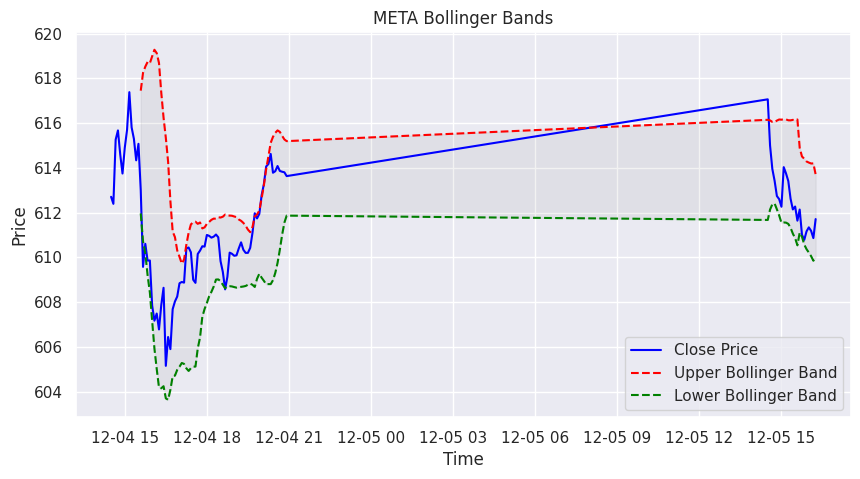

[*********************100%***********************]  1 of 1 completed


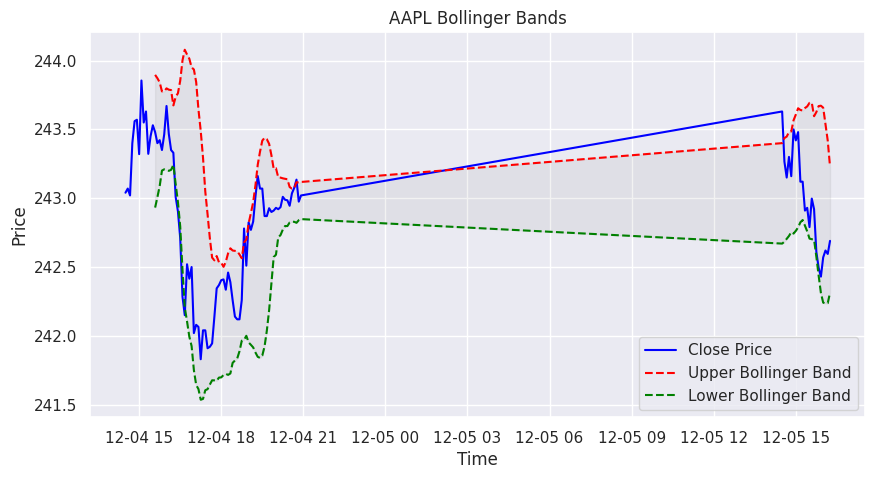

[*********************100%***********************]  1 of 1 completed


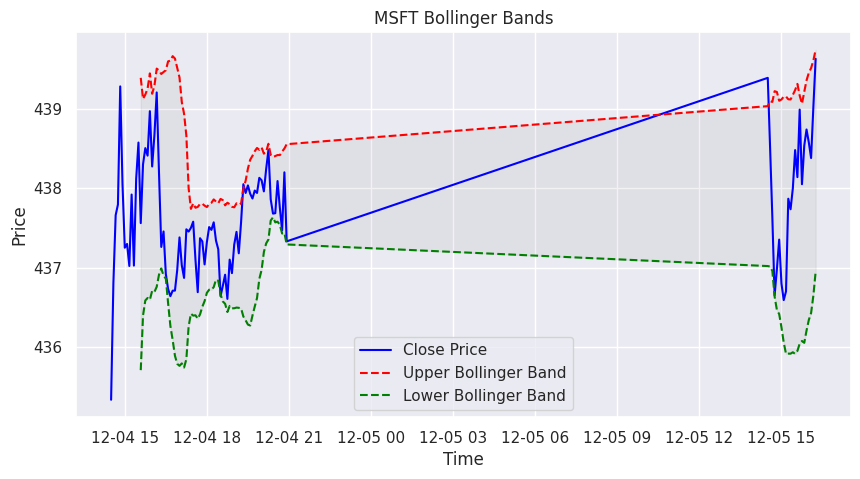

[*********************100%***********************]  1 of 1 completed


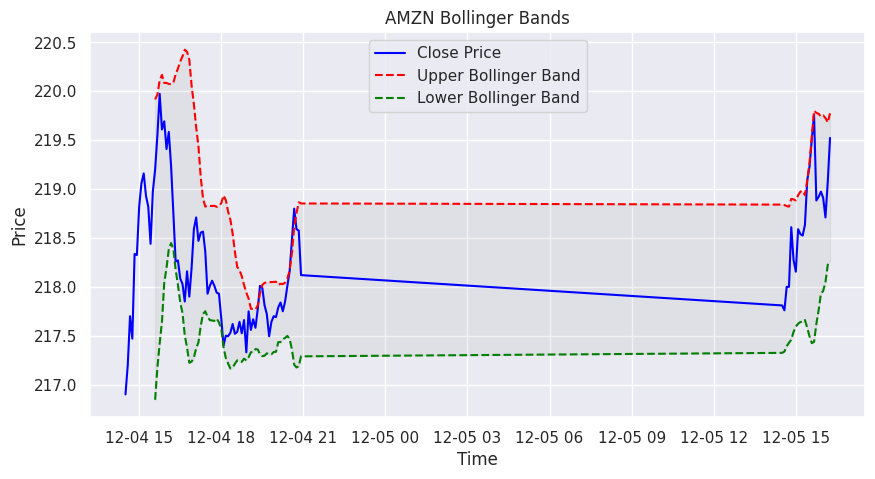

[*********************100%***********************]  1 of 1 completed


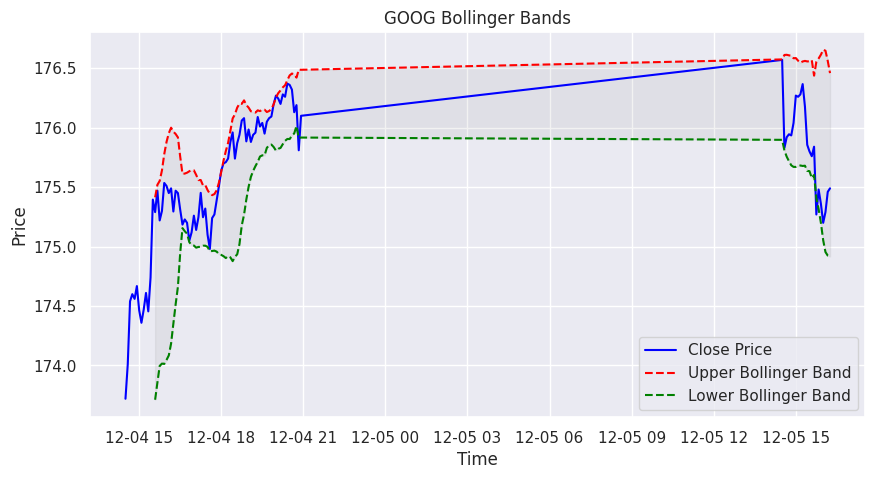

In [5]:
ticker_data_frames = []
stats = {}
for ticker in tickers:

    # Download historical data for the ticker
    data = yf.download(ticker, period="1mo", interval="5m")

    # Calculate the daily percentage change
    close = data['Close']
    upper, lower = calculate_bollinger_bands(close, window=14, num_of_std=2)
    width = upper - lower
    rsi = calculate_rsi(close, window=14)
    roc = calculate_roc(close, periods=14)
    volume = data['Volume']
    diff = data['Close'].diff(1)
    percent_change_close = data['Close'].pct_change() * 100

    # Create a DataFrame for the current ticker and append it to the list
    ticker_df = pd.DataFrame({
    ticker+'_close': close.squeeze(),
    ticker+'_width': width.squeeze(),
    ticker+'_rsi': rsi.squeeze(),
    ticker+'_roc': roc.squeeze(),
    ticker+'_volume': volume.squeeze(),
    ticker+'_diff': diff.squeeze(),
    ticker+'_percent_change_close': percent_change_close.squeeze(),
}, index=close.index)

    MEAN = ticker_df.mean()
    STD = ticker_df.std()

    # Keep track of mean and std
    for column in MEAN.index:
      stats[f"{column}_mean"] = MEAN[column]
      stats[f"{column}_std"] = STD[column]

    # Normalize the training features
    ticker_df = (ticker_df - MEAN) / STD

    ticker_data_frames .append(ticker_df)

    # Bollinger Bands Visualization
    plt.figure(figsize=(10, 5))

    # Ensure all variables are 1-dimensional and aligned
    close = close.squeeze()
    upper = upper.squeeze()
    lower = lower.squeeze()

    # Plot close price and Bollinger Bands
    plt.plot(close[:100].index, close[:100], label="Close Price", color='blue')
    plt.plot(close[:100].index, upper[:100], label="Upper Bollinger Band", linestyle='--', color='red')
    plt.plot(close[:100].index, lower[:100], label="Lower Bollinger Band", linestyle='--', color='green')

    # Fill the area between the bands
    plt.fill_between(close[:100].index, lower[:100], upper[:100], color='gray', alpha=0.1)

    # Add labels, title, and legend
    plt.title(f"{ticker} Bollinger Bands")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend()
    plt.show()


In [6]:
tickers_daily_means = []

for df in ticker_data_frames:
  dataframe_datetime = df.reset_index()
  # Ensure Datetime column is a datetime object
  dataframe_datetime['Datetime'] = pd.to_datetime(dataframe_datetime['Datetime'])

  # Calculate daily means
  daily_means = dataframe_datetime.groupby(dataframe_datetime['Datetime'].dt.date).mean()

  # Rename the date column for clarity
  daily_means.rename(columns={"Datetime": "Date"}, inplace=True)

  tickers_daily_means.append(daily_means)

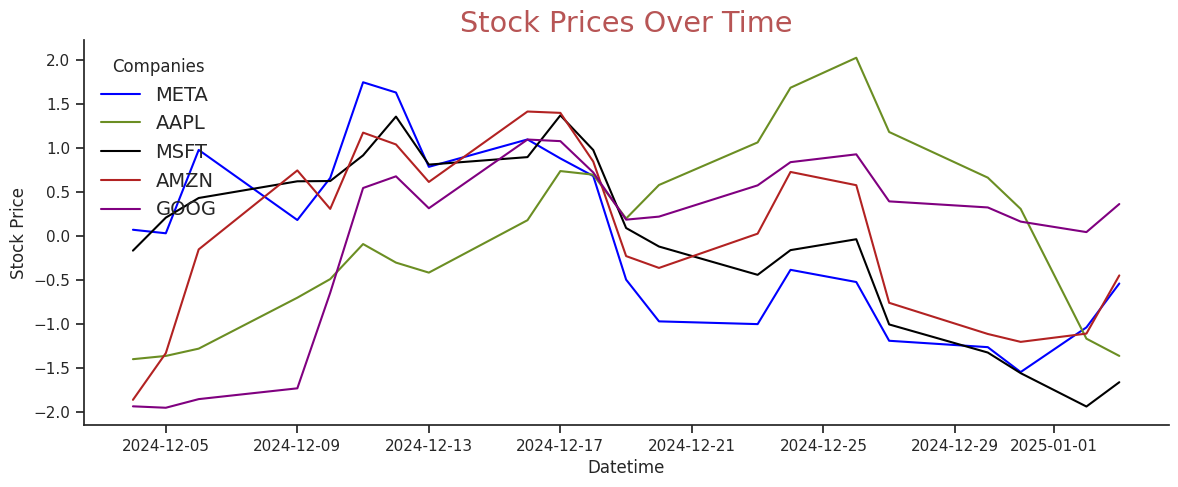

In [7]:
# Assuming `ticker_data_frames` is a list of DataFrames for each ticker
plt.figure(figsize=(14, 5))
sns.set_style("ticks")

# Map tickers to DataFrames
company_data = dict(zip(tickers, tickers_daily_means))  # Map ticker names to DataFrames
colorr = ['blue', 'olivedrab', 'black', 'firebrick', 'purple']

# Plot data for each ticker
for ticker, clr in zip(tickers, colorr):
    data = company_data[ticker]  # Get the corresponding DataFrame
    sns.lineplot(data=data, x="Datetime", y=f"{ticker}_close", color=clr, label=ticker)

# Add chart title and labels
plt.title("Stock Prices Over Time", color="brown", alpha=0.8, size="xx-large")
plt.ylabel("Stock Price")
plt.xlabel("Datetime")

# Remove spines for a cleaner look
sns.despine()

# Add legend
plt.legend(loc="upper left", frameon=False, prop={'size': 14}, title="Companies")

# Save the figure
plt.savefig('stock_prices_over_time.png', bbox_inches='tight')
plt.show()


In [8]:
# Convert stats from dict to df
stats = pd.DataFrame([stats], index=[0])
stats.head()

,META_close_mean,META_close_std,META_width_mean,META_width_std,META_rsi_mean,META_rsi_std,META_roc_mean,META_roc_std,META_volume_mean,META_volume_std,...,GOOG_rsi_mean,GOOG_rsi_std,GOOG_roc_mean,GOOG_roc_std,GOOG_volume_mean,GOOG_volume_std,GOOG_diff_mean,GOOG_diff_std,GOOG_percent_change_close_mean,GOOG_percent_change_close_std
0,610.140621,13.585722,6.203003,4.707204,49.989018,17.078652,-0.012291,0.774263,112472.427591,158970.266579,...,51.179333,17.050676,0.093916,0.889912,201974.325843,302128.140117,0.012074,0.459359,0.006886,0.244816


In [9]:
# Concatenate all ticker DataFrames
df = pd.concat(ticker_data_frames, axis=1)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
df.head()

,META_close,META_width,META_rsi,META_roc,META_volume,META_diff,META_percent_change_close,AAPL_close,AAPL_width,AAPL_rsi,...,AMZN_volume,AMZN_diff,AMZN_percent_change_close,GOOG_close,GOOG_width,GOOG_rsi,GOOG_roc,GOOG_volume,GOOG_diff,GOOG_percent_change_close
Datetime,,,,,,,,,,,,,,,,,,,,,
2024-12-04 15:40:00+00:00,-0.041677,0.281900,-0.496520,-0.644043,1.238531,-2.716388,-2.692811,-1.272788,-0.522816,0.389888,...,0.961913,0.812933,0.832289,-1.936598,-0.111326,1.660085,1.026451,-0.153694,0.365584,0.391336
2024-12-04 15:45:00+00:00,0.034018,0.453881,-0.272608,-0.361058,0.650597,0.820820,0.816934,-1.268158,-0.608811,0.381191,...,1.157821,0.989422,1.011537,-1.969166,-0.162206,1.142827,0.675853,-0.245526,-0.570521,-0.610093
2024-12-04 15:50:00+00:00,-0.021025,0.707282,-0.928735,-1.118746,-0.006193,-0.589807,-0.587786,-1.283448,-0.747584,0.350958,...,0.809616,-0.869692,-0.889116,-1.958744,-0.129237,0.830354,0.383768,-0.263793,0.147876,0.158371
2024-12-04 15:55:00+00:00,-0.020657,0.859973,-1.022708,-1.202945,0.339878,0.008065,0.007007,-1.258926,-0.754080,0.039033,...,0.539216,0.186478,0.189863,-1.928130,-0.063245,0.964538,0.496289,-0.363016,0.485300,0.519452
2024-12-04 16:00:00+00:00,-0.168607,1.193515,-1.124638,-1.402603,0.538765,-1.592239,-1.586980,-1.215210,-0.732681,0.096235,...,1.586736,-0.678588,-0.694819,-1.931388,-0.030768,0.986930,0.506013,-0.192926,-0.080727,-0.086324


In [10]:
# Shift the df data to create labels
labels = df.shift(-1)

# Drop the last row in both percent_change_data and labels as it won't have a corresponding label
df = df.iloc[:-1]
labels = labels.iloc[:-1]

In [11]:
# Sequence len = 24 means that we have 2 hours of 5 min data
SEQUENCE_LEN = 24

# Function to create X-day sequences for each ticker
def create_sequences(data, labels, mean, std, sequence_length=SEQUENCE_LEN):
    sequences = []
    lab = []
    data_size = len(data)

    # + 12 because we want to predict the next hour
    for i in range(data_size - (sequence_length + 13)):
      if i == 0:
        continue

      sequences.append(data[i:i + sequence_length])
      lab.append([labels[i-1], labels[i + 12], mean[0], std[0]])

    for i in range(0, len(lab)):
      last_price_data = sequences[i][-1][0]
      last_price_label = lab[i][0]

      if not last_price_data == last_price_label:
        print(f"ERROR : {last_price_data=} and {last_price_label=} are not equal")

    return np.array(sequences), np.array(lab)

In [12]:
sequences_dict = {}
sequences_labels = {}
for ticker in tickers:

    # Extract close and volume data for the ticker
    close = df[ticker+'_close'].values
    width = df[ticker+'_width'].values
    rsi = df[ticker+'_rsi'].values
    roc = df[ticker+'_roc'].values
    volume = df[ticker+'_volume'].values
    diff = df[ticker+'_diff'].values
    pct_change = df[ticker+'_percent_change_close'].values

    # Combine close and volume data
    ticker_data = np.column_stack((close,
                                   width,
                                   rsi,
                                   roc,
                                   volume,
                                   diff,
                                   pct_change))

    # Generate sequences
    attribute = ticker+"_close"
    ticker_sequences, lab = create_sequences(ticker_data,
                                             labels[attribute].values[SEQUENCE_LEN-1:],
                                             stats[attribute+"_mean"].values,
                                             stats[attribute+"_std"].values)

    sequences_dict[ticker] = ticker_sequences
    sequences_labels[ticker] = lab


print(sequences_dict["META"])
print(sequences_labels["META"])

[[[ 3.40182481e-02  4.53880721e-01 -2.72607563e-01 ...  6.50596962e-01
    8.20819923e-01  8.16934216e-01]
  [-2.10250334e-02  7.07282098e-01 -9.28735162e-01 ... -6.19252651e-03
   -5.89807264e-01 -5.87785641e-01]
  [-2.06566405e-02  8.59972994e-01 -1.02270839e+00 ...  3.39878479e-01
    8.06482698e-03  7.00659779e-03]
  ...
  [-8.39483275e-02  5.32062440e-02  2.73533349e-01 ... -9.98389695e-02
   -9.68676103e-01 -9.65298879e-01]
  [-9.42633270e-02  5.67766486e-02  5.66697872e-02 ... -3.08475469e-01
   -1.07205145e-01 -1.07964867e-01]
  [ 6.92173813e-04 -1.35127755e-01  1.57436919e+00 ... -3.28101781e-01
    1.02862580e+00  1.02521466e+00]]

 [[-2.10250334e-02  7.07282098e-01 -9.28735162e-01 ... -6.19252651e-03
   -5.89807264e-01 -5.87785641e-01]
  [-2.06566405e-02  8.59972994e-01 -1.02270839e+00 ...  3.39878479e-01
    8.06482698e-03  7.00659779e-03]
  [-1.68606799e-01  1.19351496e+00 -1.12463807e+00 ...  5.38764728e-01
   -1.59223915e+00 -1.58697978e+00]
  ...
  [-9.42633270e-02  5.6

In [13]:
# Combine data and labels from all tickers
all_sequences = []
all_labels = []

for ticker in tickers:
    all_sequences.extend(sequences_dict[ticker])
    all_labels.extend(sequences_labels[ticker])

# Convert to numpy arrays
all_sequences = np.array(all_sequences)
all_labels = np.array(all_labels)

In [14]:
np.random.seed(42)
shuffled_indices = np.random.permutation(len(all_sequences))
all_sequences = all_sequences[shuffled_indices]
all_labels = all_labels[shuffled_indices]

train_size = int(len(all_sequences) * 0.9)

# Split sequences
train_sequences = all_sequences[:train_size]
train_labels    = all_labels[:train_size]

other_sequences = all_sequences[train_size:]
other_labels    = all_labels[train_size:]

shuffled_indices = np.random.permutation(len(other_sequences))
other_sequences = other_sequences[shuffled_indices]
other_labels = other_labels[shuffled_indices]

val_size = int(len(other_sequences) * 0.5)

validation_sequences = other_sequences[:val_size]
validation_labels = other_labels[:val_size]

test_sequences = other_sequences[val_size:]
test_labels = other_labels[val_size:]

In [15]:
print(validation_sequences.shape)

(387, 24, 7)


In [16]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Add()([x, inputs])

    # Feed Forward Part
    y = LayerNormalization(epsilon=1e-6)(x)
    y = Dense(ff_dim, activation="relu")(y)
    y = Dropout(dropout)(y)
    y = Dense(inputs.shape[-1])(y)
    return Add()([y, x])

def build_transformer_model(input_shape, head_size, num_heads, ff_dim, num_layers, dropout=0):
    inputs = Input(shape=input_shape)
    x = inputs

    # Create multiple layers of the Transformer block
    for _ in range(num_layers):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    # Final part of the model
    x = GlobalAveragePooling1D()(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    outputs = Dense(1, activation="linear")(x)

    # Compile model
    model = Model(inputs=inputs, outputs=outputs)
    return model



In [17]:
class CDAM:
  def __init__(self, init_lr=0.001):
    self.init_lr = init_lr
    self.balance_hyper = 1.5
    # self.rolling_window_size = 20 # Adjust rolling window size as needed
    # self.error_rate = []
    self.drift_state = 0  # 0: Normal, 1: Warning, 2: Drift
    #new
    self.mean_error_min = float('inf')
    self.std_error_min = float('inf')

  def monitor_error(self, predictions, true_values):
    errors = np.abs(predictions - true_values)

    # # Extend `self.error_rate` with individual scalar errors
    # self.error_rate.extend(error.flatten())  # Flatten ensures 1D array

    # if len(self.error_rate) > self.rolling_window_size:
    #     self.error_rate = self.error_rate[-(self.rolling_window_size):]

    mean_error = np.mean(errors)
    std_error = np.std(errors)
    print("Mean Error:", mean_error, "Std Error:", std_error)
    # if mean_error > threshold * self.drift_factor:
    #     self.drift_state = 2  # Drift
    # elif mean_error > threshold * self.warning_factor:
    #     self.drift_state = 1  # Warning
    # else:
    #     self.drift_state = 0  # Normal

    # return self.drift_state
    if mean_error + std_error < self.mean_error_min + self.std_error_min:
      self.mean_error_min, self.std_error_min = mean_error, std_error

    if mean_error + std_error >= self.mean_error_min + 2 * self.std_error_min:
      self.drift_state = 2  # Drift level
      print("Drift state: Drift")

    elif mean_error + std_error >= self.mean_error_min + (2/3) * self.std_error_min:
      self.drift_state = 1  # Warning level
      print("Drift state: Warning")

    else:
      self.drift_state = 0  # Normal level
      print("Drift state: Normal")

    return self.drift_state

  def calculate_anomaly_score(self, predictions, true_values):
    # Calculate squared errors (anomaly scores)
    anomaly_scores = (predictions - true_values) ** 2
    # print("Anomaly Score:", anomaly_scores)
    return anomaly_scores

  def adjust_learning_rate(self, optimizer, anomaly_score):
    # # Adjust the learning rate dynamically based on drift state
    # if epoch < (int(0.30 * EPOCHS)): # 30% of epochs for warm-up
    #   optimizer.learning_rate.assign(self.init_lr)
    #   print("Came here : Warm-up")
    adjusted_lr = self.init_lr
    if self.drift_state == 2:
      adjusted_lr *= self.balance_hyper * anomaly_score
      print("Came here : Drift")
    elif self.drift_state == 1:
      adjusted_lr *= anomaly_score
      print("Came here : Warning")
    # Ensure learning rate stays within reasonable bounds
    adjusted_lr = np.clip(adjusted_lr, 1e-8, 1e-2)  # Min and max learning rates
    optimizer.learning_rate.assign(adjusted_lr)

    # Print the current learning rate
    print("Learning rate:", optimizer.learning_rate.numpy())

In [18]:
class CDAMLearningRateScheduler(tf.keras.callbacks.Callback):
    def __init__(self, optimizer, cdam, validation_data, verbose=1):
        super().__init__()
        self.optimizer = optimizer
        self.cdam = cdam
        self.validation_data = validation_data
        self.verbose = verbose

    def on_batch_end(self, batch, logs=None):
        # Extract loss from logs
        loss = logs.get('loss', 0.0)

        # Extract validation inputs and true values
        val_x, val_y = self.validation_data

        # Monitor drift and adjust the learning rate
        predictions = self.model.predict(val_x, verbose=0)

        print("Predictions:", predictions)
        print("True Values:", val_y)

        drift_state = self.cdam.monitor_error(predictions, val_y) #add a threshold if needed

        anomaly_scores = self.cdam.calculate_anomaly_score(predictions, val_y)
        anomaly_score = np.mean(anomaly_scores)
        print("Anomaly Score:", anomaly_score)

        self.cdam.adjust_learning_rate(self.optimizer, anomaly_score)

        # Optionally log the new learning rate
        if self.verbose > 0:
            current_lr = tf.keras.backend.get_value(self.optimizer.learning_rate)
            print(f"Batch {batch + 1}: Drift state={self.cdam.drift_state}, Adjusted learning rate={current_lr:.5f}")


In [19]:
def custom_mae_loss(y_true, y_pred):
    y_true_next = tf.cast(y_true[:, 1], tf.float64)
    y_pred_next = tf.cast(y_pred[:, 0], tf.float64)
    abs_error = tf.abs(y_true_next - y_pred_next)

    return tf.reduce_mean(abs_error)

def dir_acc(y_true, y_pred):
    mean, std = tf.cast(y_true[:, 2], tf.float64), tf.cast(y_true[:, 3], tf.float64)

    y_true_prev = (tf.cast(y_true[:, 0], tf.float64) * std) + mean
    y_true_next = (tf.cast(y_true[:, 1], tf.float64) * std) + mean
    y_pred_next = (tf.cast(y_pred[:, 0], tf.float64) * std) + mean

    true_change = y_true_next - y_true_prev
    pred_change = y_pred_next - y_true_prev

    correct_direction = tf.equal(tf.sign(true_change), tf.sign(pred_change))

    return tf.reduce_mean(tf.cast(correct_direction, tf.float64))

In [20]:
# Model parameters
input_shape = train_sequences.shape[1:]
head_size = 256
num_heads = 16
ff_dim = 1024
num_layers = 12
dropout = 0.20

# Build the model
model = build_transformer_model(input_shape, head_size, num_heads, ff_dim, num_layers, dropout)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 24, 7)          │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 24, 7)          │             14 │ input_layer[0][0]      │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 24, 7)          │        126,983 │ layer_normalization[0… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 24, 7)          │              0 │ multi_head_attention[… │
│                           │                        │                │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 24, 7)          │             14 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 24, 1024)       │          8,192 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 24, 1024)       │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 24, 7)          │          7,175 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 24, 7)          │              0 │ dense_1[0][0],         │
│                           │                        │                │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 24, 7)          │             14 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 24, 7)          │        126,983 │ layer_normalization_2… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 24, 7)          │              0 │ multi_head_attention_… │
│                           │                        │                │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_3     │ (None, 24, 7)          │             14 │ add_2[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 24, 1024)       │          8,192 │ layer_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 24, 1024)       │              0 │ dense_2[0][0]          │
├──────────────────────

 Total params: 1,708,558 (6.52 MB)

 Trainable params: 1,708,558 (6.52 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss=custom_mae_loss, metrics=[dir_acc])

cdam = CDAM(init_lr=0.001)

# Training loop
EPOCHS = 100
BATCH_SIZE = 64

In [22]:
# Define a callback to save the best model
checkpoint_callback_train = ModelCheckpoint(
    "transformer_train_model.keras",  # Filepath to save the best model
    monitor="dir_acc",  #"loss",  # Metric to monitor
    save_best_only=True,  # Save only the best model
    mode="max",  # Minimize the monitored metric
    verbose=1,  # Display progress
)

# Define a callback to save the best model
checkpoint_callback_val = ModelCheckpoint(
    "transformer_val_model.keras",  # Filepath to save the best model
    monitor="val_dir_acc", #"val_loss",  # Metric to monitor
    save_best_only=True,  # Save only the best model
    mode="max",  # Minimize the monitored metric
    verbose=1,  # Display progress
)

In [23]:
cdam_lr_scheduler = CDAMLearningRateScheduler(
    optimizer=optimizer,
    cdam=cdam,
    validation_data=(validation_sequences, validation_labels),  # Pass validation data here
    verbose=1
)


model.fit(
    train_sequences, train_labels,
    validation_data=(validation_sequences, validation_labels),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    callbacks=[checkpoint_callback_train, checkpoint_callback_val, cdam_lr_scheduler]
)


Epoch 1/100
Predictions: [[ 2.4830983 ]
 [ 0.71306545]
 [ 2.4328904 ]
 [ 2.2823358 ]
 [ 2.2581747 ]
 [ 2.227453  ]
 [ 2.328756  ]
 [ 0.27049223]
 [ 2.576562  ]
 [ 1.7715389 ]
 [ 2.4040227 ]
 [ 2.360707  ]
 [ 0.7492911 ]
 [ 1.957225  ]
 [ 0.33146256]
 [ 2.051644  ]
 [ 2.0751987 ]
 [ 2.1936421 ]
 [ 2.256519  ]
 [ 2.274981  ]
 [-0.2408777 ]
 [ 1.6032937 ]
 [ 2.2588086 ]
 [ 2.3415048 ]
 [ 2.0796108 ]
 [ 2.4828799 ]
 [ 2.225265  ]
 [ 2.0561209 ]
 [ 2.1601186 ]
 [ 0.53615636]
 [-0.02141677]
 [ 2.5256553 ]
 [ 2.148728  ]
 [-1.1842066 ]
 [ 1.2402799 ]
 [ 1.6448338 ]
 [ 2.2292604 ]
 [ 2.5649724 ]
 [ 1.4696475 ]
 [ 2.498772  ]
 [ 2.2793677 ]
 [ 2.5202212 ]
 [ 1.700425  ]
 [ 2.4903738 ]
 [ 2.3407285 ]
 [ 1.9285561 ]
 [ 1.7220715 ]
 [ 2.2148519 ]
 [ 2.3517394 ]
 [ 2.5669727 ]
 [ 1.7335242 ]
 [ 1.7777686 ]
 [ 0.5419532 ]
 [ 2.249286  ]
 [ 2.3413057 ]
 [ 2.4929092 ]
 [ 1.7045085 ]
 [ 2.4278166 ]
 [ 1.3445561 ]
 [ 2.4513965 ]
 [ 2.5154693 ]
 [ 1.2214144 ]
 [ 2.4396546 ]
 [ 2.389045  ]
 [ 2.415246  ]


KeyboardInterrupt: 